I need this to figure out noise values. The matrices I'm trying to figure out:
- process noise covariance matrix $Q$
- measurement noise covariance matrix $R$
- state covariance matrix $P$

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('data/sensor_data_stationary.csv')


df.head()

,Accel_X,Accel_Y,Accel_Z,Magneto_X,Magneto_Y,Magneto_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Quaternion_W,Quaternion_X,Quaternion_Y,Quaternion_Z,Pressure,Temperature,Time
0,0.32,0.18,9.78,12.6875,-15.5625,-39.8750,0.0000,0.1250,0.0000,0.31,0.06,9.8,0.365601,0.016113,-0.002563,0.930664,83064.851562,23.358643,169828.0
1,0.34,0.17,9.77,12.6875,-16.2500,-40.6875,0.0000,0.0625,0.0625,0.31,0.06,9.8,0.365601,0.016113,-0.002563,0.930664,101695.945312,29.876236,169868.0
2,0.32,0.17,9.80,13.0000,-15.5625,-39.8750,0.0625,0.0000,0.0000,0.31,0.06,9.8,0.365601,0.016113,-0.002563,0.930664,101696.210938,29.899881,169908.0
3,0.34,0.17,9.82,12.6875,-15.8750,-40.6875,0.0000,-0.1250,-0.0625,0.31,0.06,9.8,0.365601,0.016113,-0.002563,0.930664,101696.289062,29.934338,169948.0
4,0.31,0.19,9.80,12.6875,-15.8750,-40.6875,-0.0625,-0.1250,0.0625,0.31,0.06,9.8,0.365601,0.016113,-0.002563,0.930664,101695.515625,29.971138,169988.0


## Process Noise Covariance Matrix
The diagonal elements contain variances for each state variable and off-diagonal elements contain covariances between different state variables. 
We can start off with diagonal matrix with small positive values. Consider the maximum expected change in each state variable. Set diagonal elements to (max_change/3)² to cover 99.7% of possible variations. Adjust based on system performance.

sources: [how to initialise error covariance matrix and process noise covariance matrix](https://www.researchgate.net/post/How-to-initialize-the-error-covariance-matrix-and-process-noise-covariance-matrix-How-are-they-different-and-in-what-way-they-impact-the-filter)



(840, 3)
Covariance Matrix:
[[ 4.56651466e-03 -1.02874117e-03 -6.92057403e-05]
 [-1.02874117e-03  9.01927163e-03 -1.04132302e-03]
 [-6.92057403e-05 -1.04132302e-03  5.96346074e-03]]


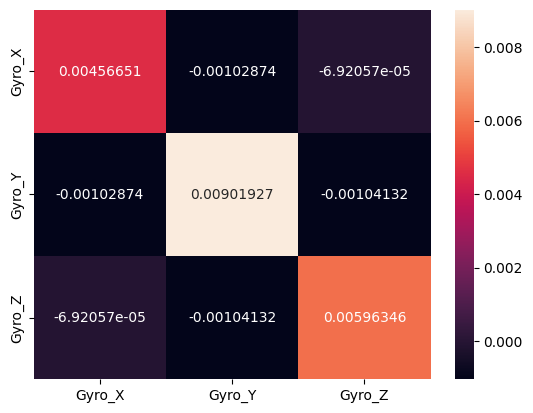

In [13]:
measurement_labels = ['Gyro_X','Gyro_Y','Gyro_Z']
acc_measurements = np.array(df[measurement_labels]) # each 'column' is a new measurement
print(acc_measurements.shape)
covariance_matrix = np.cov(acc_measurements, rowvar=False)
print("Covariance Matrix:")
print(covariance_matrix)

sns.heatmap(covariance_matrix, annot=True, fmt='g', xticklabels=measurement_labels, yticklabels=measurement_labels)
plt.show()

### Measurement Noise Covariance Matrix
We can use manufacturer-provided accuracy specifications,

$$R = \begin{bmatrix}
\sigma_1^2 &0&0\\
0&\sigma_2^2&0\\
0&0&\sigma_3^2\end{bmatrix}$$

where $\sigma_i$ is the sensor's standard deviation. Alternatively,

1. Take multiple static measurements
2. Calculate variance of measurements
3. Use these variances as diagonal elements of R



In [14]:
R_manufactured = np.array([
    [0.01, 0, 0],
    [0, 0.01, 0],
    [0, 0, 0.01]
])

R_empirical = np.array([
    [np.var(df['Gyro_X']), 0, 0,0,0,0,0],
    [0, np.var(df['Gyro_Y']), 0,0,0,0,0],
    [0, 0, np.var(df['Gyro_Z']),0,0,0,0],
    [0, 0, 0 ,np.var(df['Quaternion_W']),0,0,0],
    [0, 0, 0, 0, np.var(df['Quaternion_X']),0,0],
    [0, 0, 0, 0, 0, np.var(df['Quaternion_Y']), 0],
    [0, 0, 0,0,0,0, np.var(df['Quaternion_Z'])]
])

print("Manufacturer-proviced accuracy specifications gives: \n",R_manufactured)
print("Empirically computed variances gives: \n",R_empirical)

Manufacturer-proviced accuracy specifications gives: 
 [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
Empirically computed variances gives: 
 [[0.00456108 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.00900853 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.00595636 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


### Initial State Covariance Matrix
The most common approach is $$P=p\begin{bmatrix}1&0&0\\0&1&0\\0&0&1\end{bmatrix}$$
with $p$ being some large number. Use larger values to indicate high initial uncertainty.
